
📊 Processing IOWait with TUNA Multi-Method Outlier Detection:
  🔍 CPU STRESS:
    ⚠️  Unstable CPUs detected: 8/10 (CoV > 15%)
    🎯 Applied TUNA noise smoothing using baseline reference
    ✅ Cleaned 70 consensus outliers
    📈 Average CoV improvement: 8.77%
  🔍 BASELINE:
    ⚠️  Unstable CPUs detected: 8/10 (CoV > 15%)
    ✅ Cleaned 53 consensus outliers
    📈 Average CoV improvement: 8.30%

📊 Processing IRQ with TUNA Multi-Method Outlier Detection:
  🔍 CPU STRESS:
    ⚠️  Unstable CPUs detected: 3/10 (CoV > 15%)
    🎯 Applied TUNA noise smoothing using baseline reference
    ✅ Cleaned 22 consensus outliers
    📈 Average CoV improvement: 3.07%
  🔍 BASELINE:
    ⚠️  Unstable CPUs detected: 8/10 (CoV > 15%)
    ✅ Cleaned 22 consensus outliers
    📈 Average CoV improvement: 49.07%

📊 Processing System with TUNA Multi-Method Outlier Detection:
  🔍 CPU STRESS:
    ⚠️  Unstable CPUs detected: 8/10 (CoV > 15%)
    🎯 Applied TUNA noise smoothing using baseline reference
    ✅ Cleaned 34 con

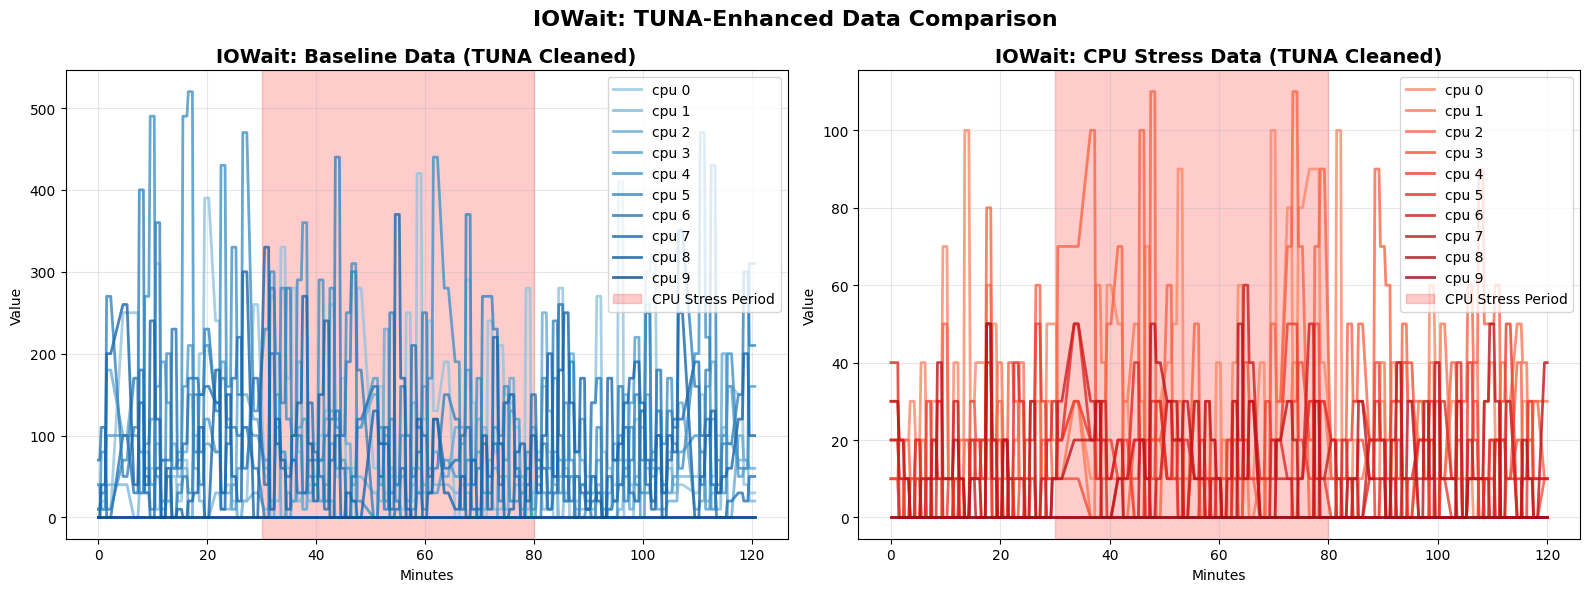

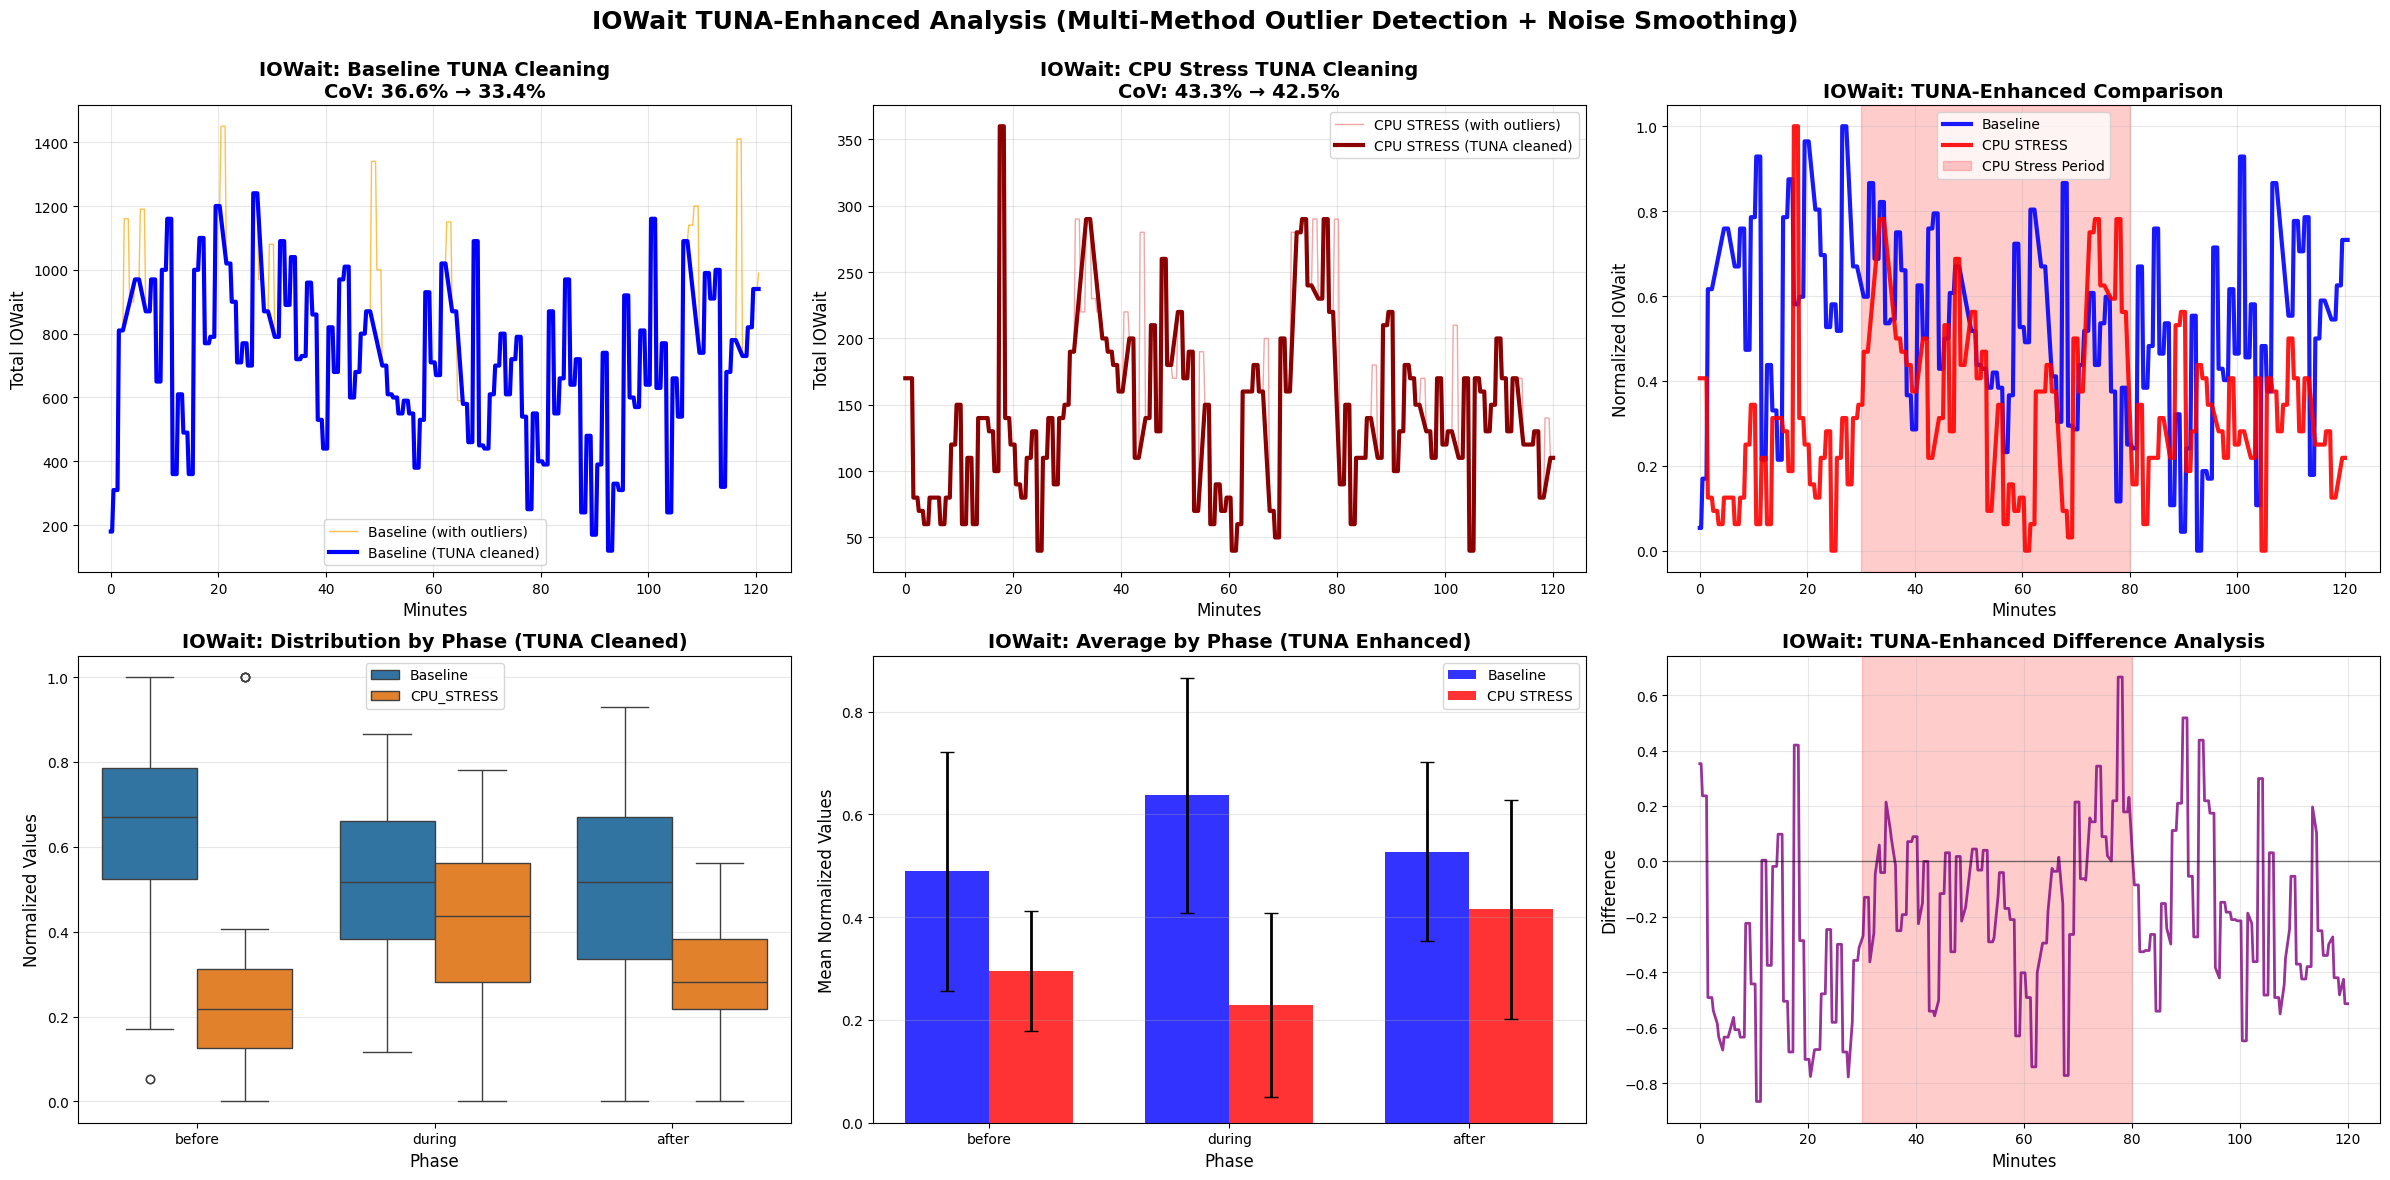


IOWAIT - TUNA-ENHANCED ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4890  0.2331  0.0000  0.9286
before  0.6371  0.2283  0.0536  1.0000
during  0.5277  0.1749  0.1161  0.8661

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.2950  0.1168  0.0  0.5625
before  0.2292  0.1788  0.0  1.0000
during  0.4152  0.2125  0.0  0.7812

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 15.41, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  5.79, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=  9.42, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -64.03% (↘️ DECREASE)
  DURING  :  -21.32% (↘️ DECREASE)
  AFTER   :  -39.66% (↘️ DECREASE)

🎯 TUNA ENHANCEMENTS APPLIED:
  ✅ Multi-method consensus outlier detection
  ✅ CoV-based instability assessment
  ✅ Component-level noise smoothing
  ✅ Baseline-referenced noise reduction

📋 INDIV

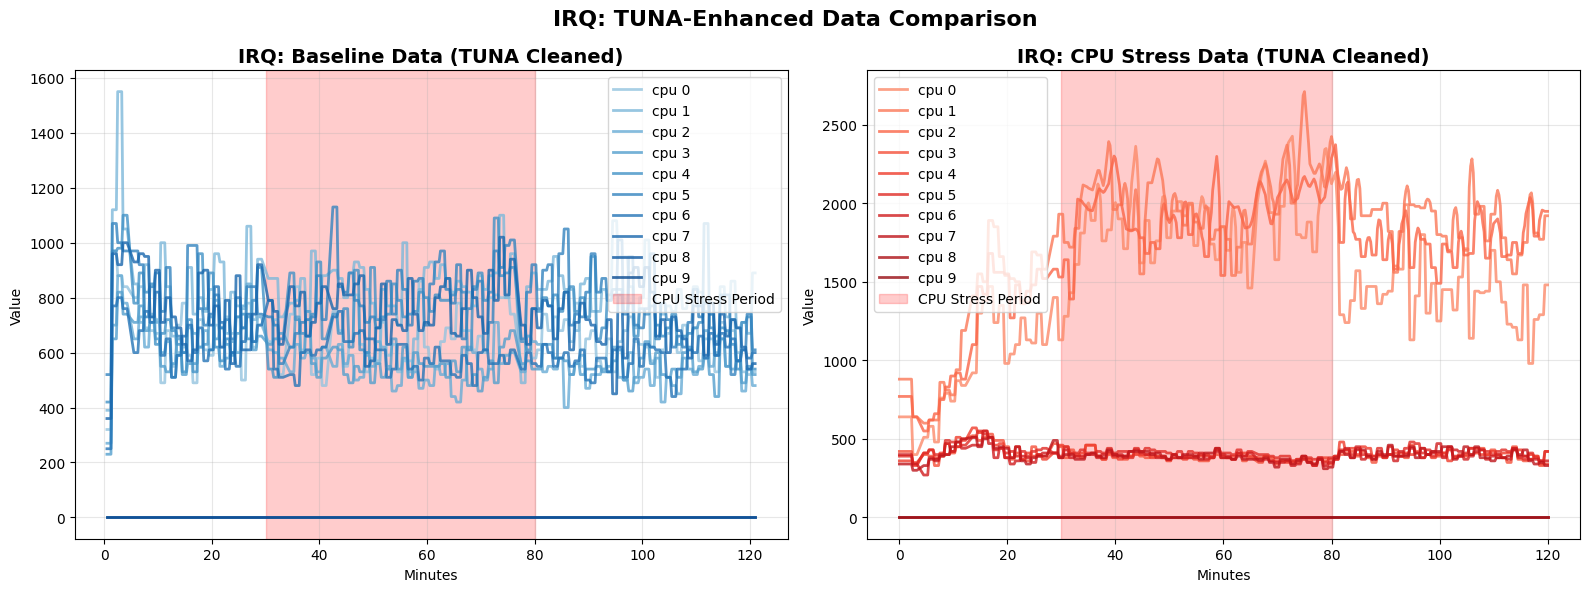

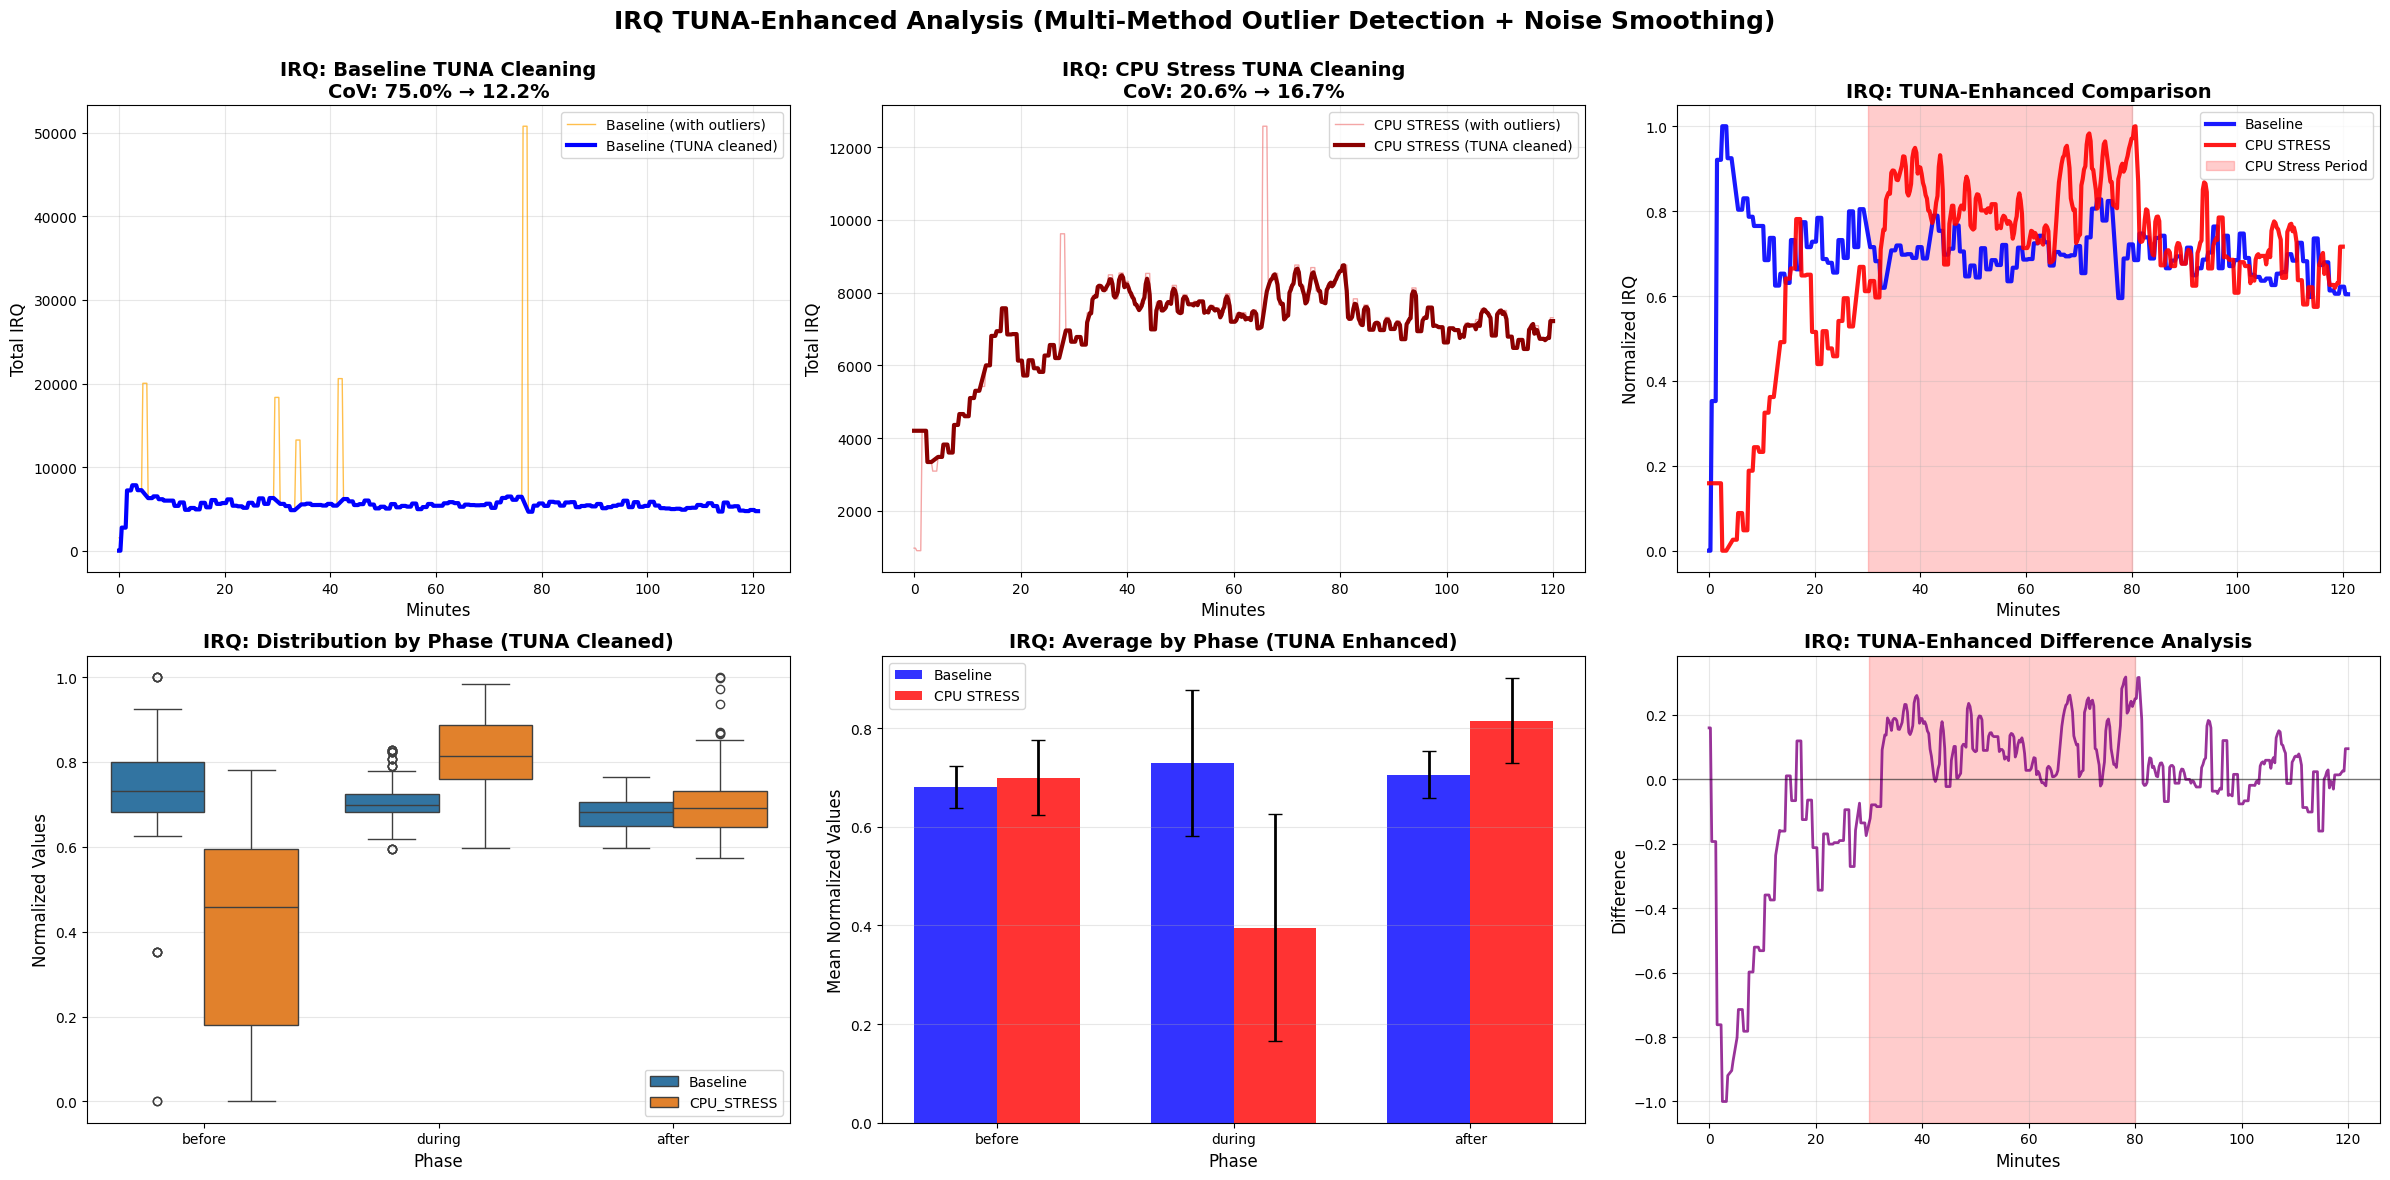


IRQ - TUNA-ENHANCED ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6803  0.0427  0.5977  0.7637
before  0.7296  0.1487  0.0000  1.0000
during  0.7058  0.0475  0.5951  0.8276

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7000  0.0757  0.5744  1.0000
before  0.3957  0.2301  0.0000  0.7813
during  0.8152  0.0866  0.5966  0.9830

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 13.35, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-15.71, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -2.90, p=  0.0040 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -45.76% (↘️ DECREASE)
  DURING  :  +15.51% (↗️ INCREASE)
  AFTER   :   +2.90% (↗️ INCREASE)

🎯 TUNA ENHANCEMENTS APPLIED:
  ✅ Multi-method consensus outlier detection
  ✅ CoV-based instability assessment
  ✅ Component-level noise smoothing
  ✅ Baseline-referenced noise reduct

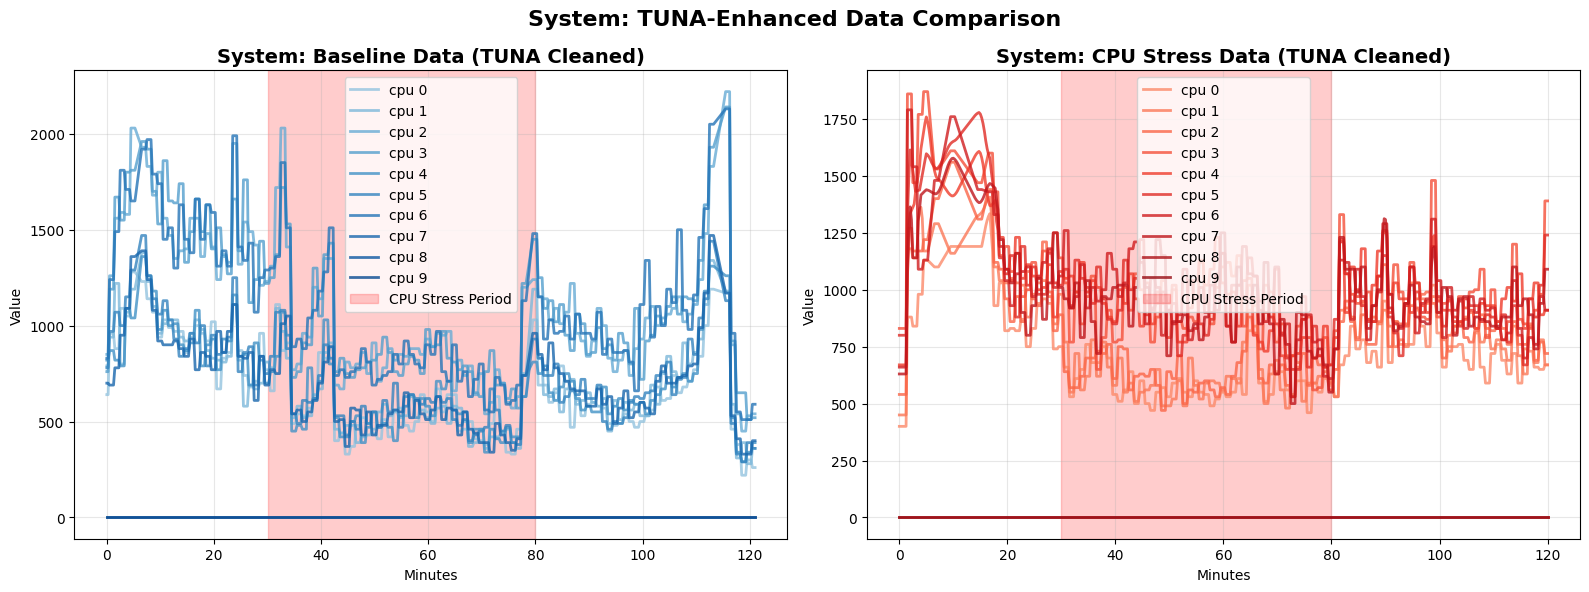

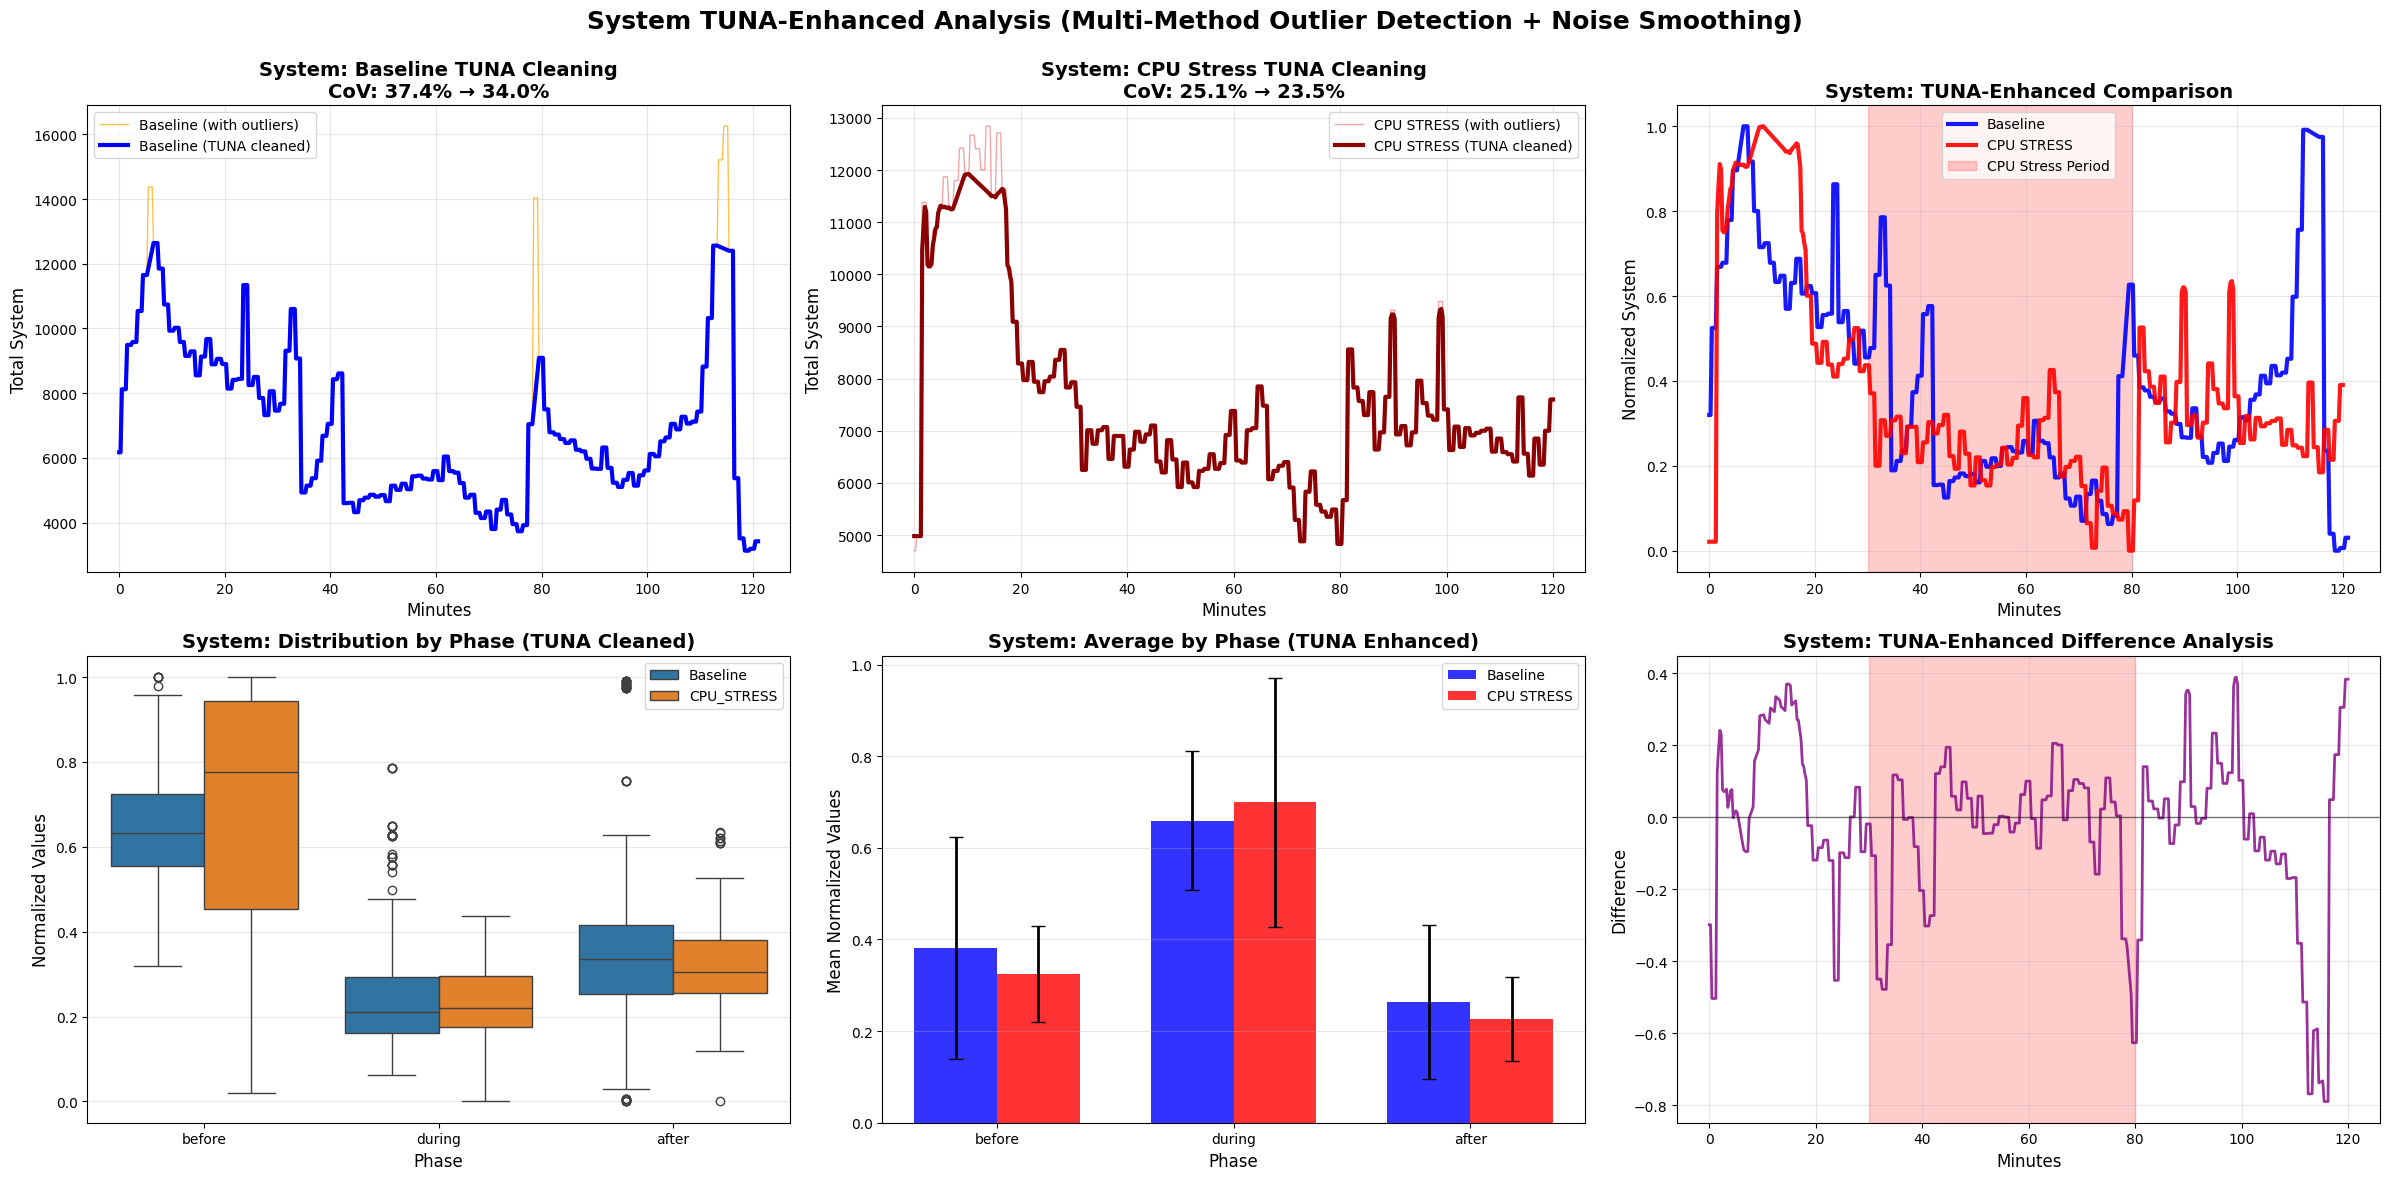


SYSTEM - TUNA-ENHANCED ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3812  0.2432  0.0000  0.9916
before  0.6595  0.1508  0.3197  1.0000
during  0.2630  0.1681  0.0631  0.7855

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3245  0.1038  0.0000  0.6351
before  0.6993  0.2713  0.0211  1.0000
during  0.2266  0.0919  0.0000  0.4370

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.40, p=  0.1614 (❌ NOT SIGNIFICANT)
  DURING  : t=  2.69, p=  0.0074 (✅ SIGNIFICANT)
  AFTER   : t=  2.72, p=  0.0069 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :   +6.04% (↗️ INCREASE)
  DURING  :  -13.84% (↘️ DECREASE)
  AFTER   :  -14.87% (↘️ DECREASE)

🎯 TUNA ENHANCEMENTS APPLIED:
  ✅ Multi-method consensus outlier detection
  ✅ CoV-based instability assessment
  ✅ Component-level noise smoothing
  ✅ Baseline-referenced noise

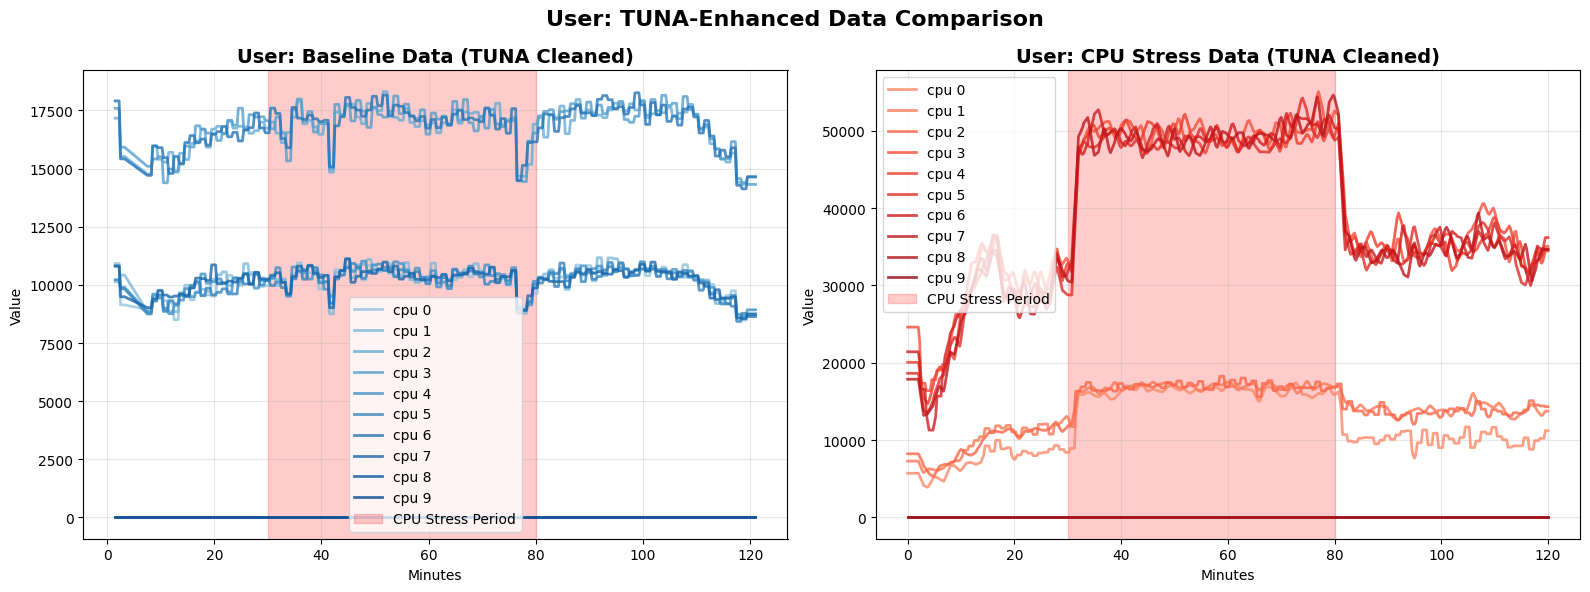

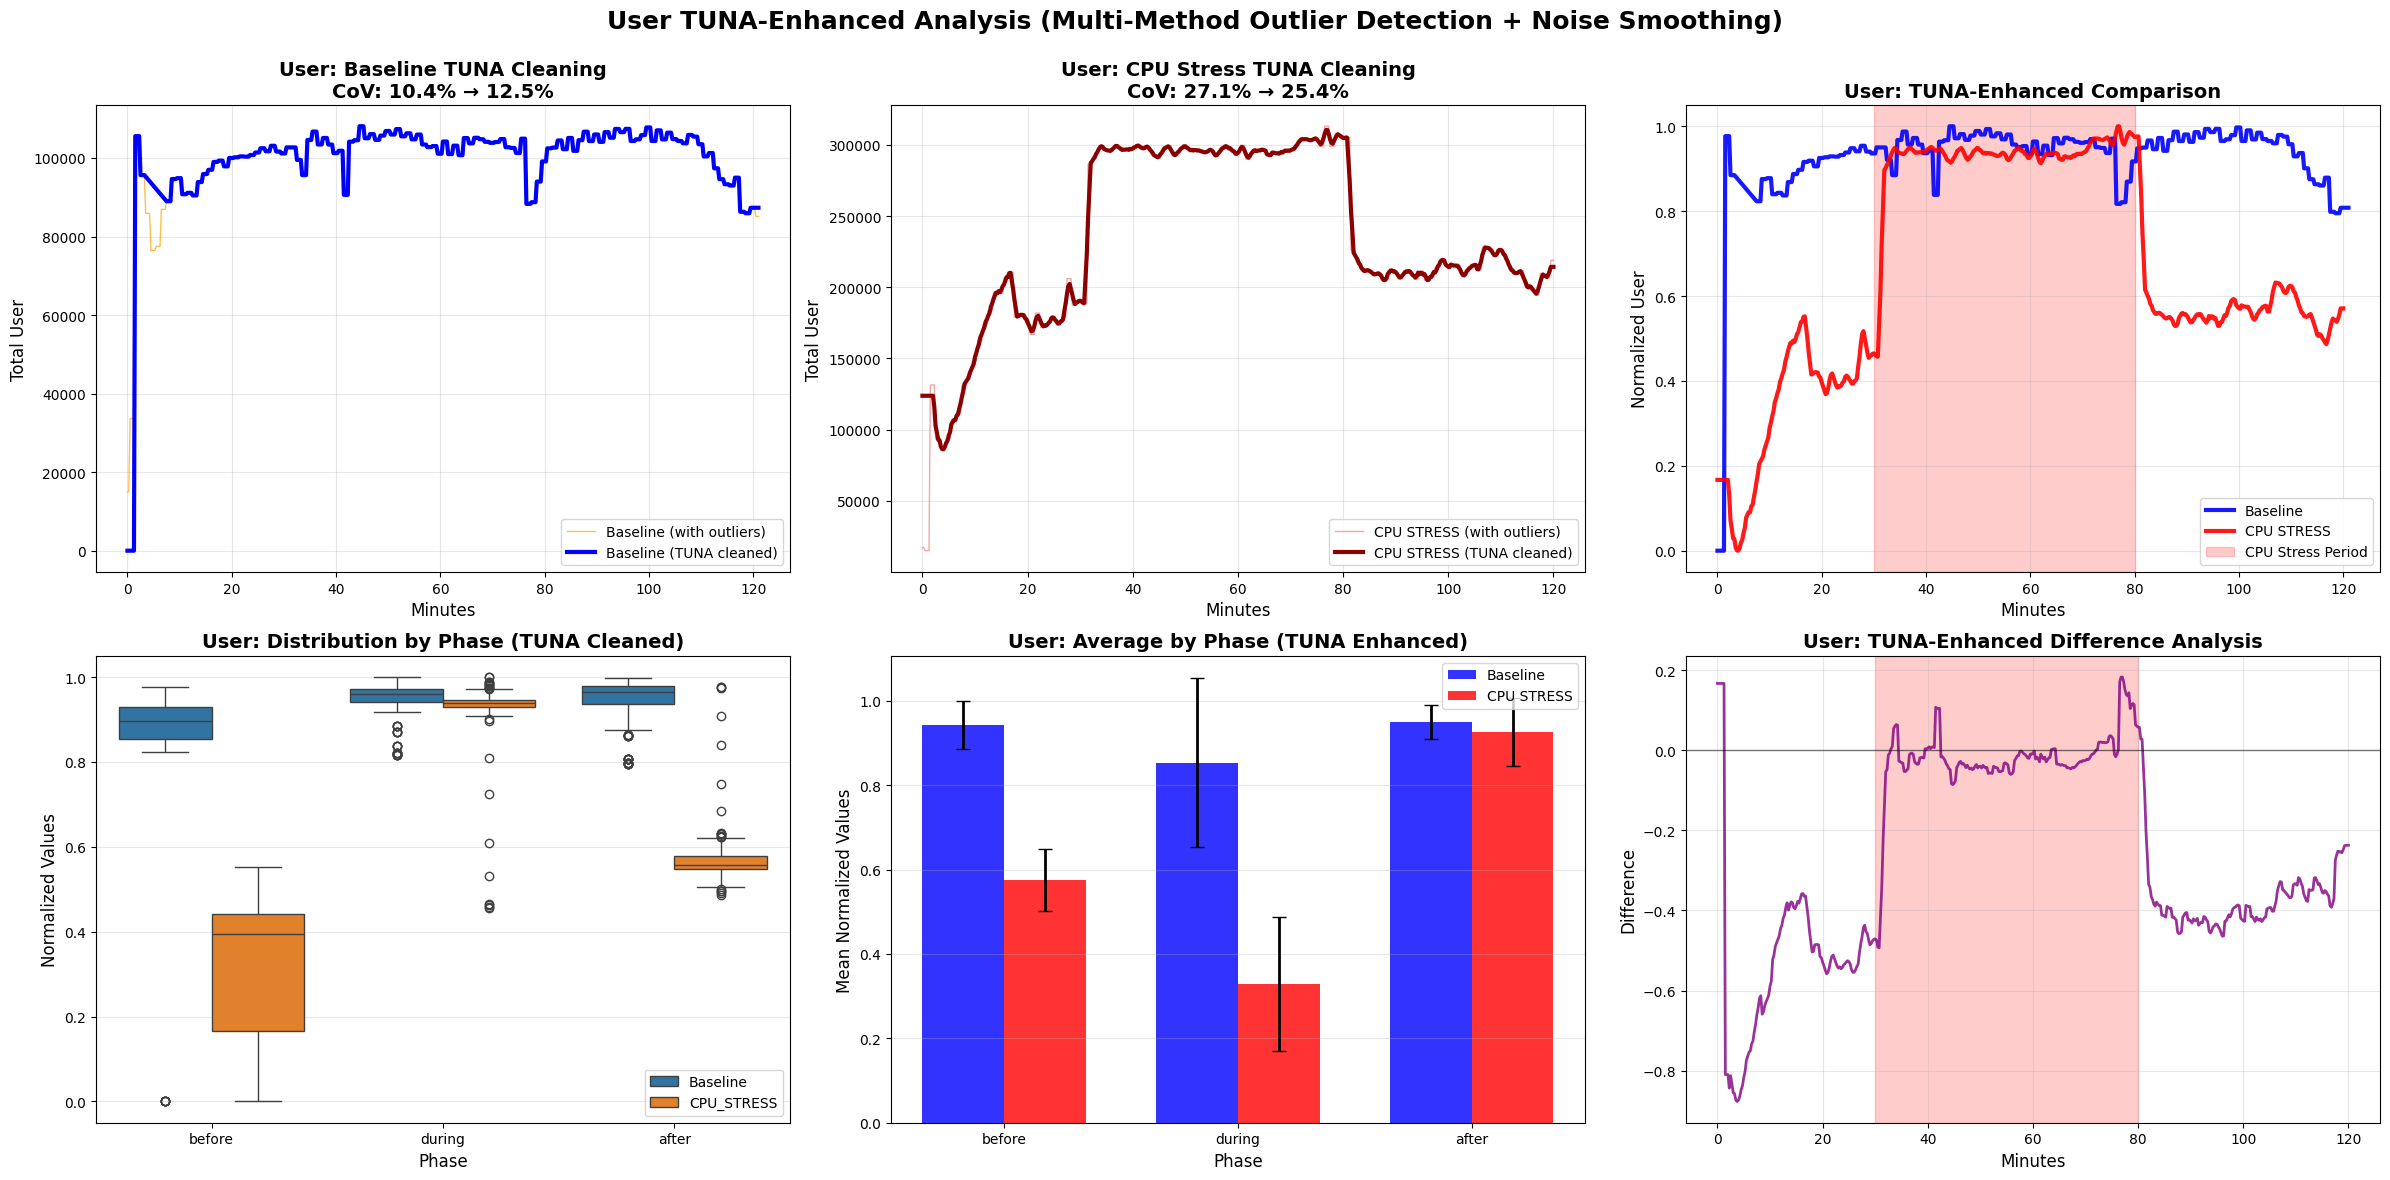


USER - TUNA-ENHANCED ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9421  0.0564  0.7950  0.9971
before  0.8533  0.2008  0.0000  0.9767
during  0.9502  0.0397  0.8171  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5753  0.0740  0.4866  0.9762
before  0.3286  0.1587  0.0000  0.5521
during  0.9267  0.0801  0.4569  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 22.46, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  3.72, p=  0.0002 (✅ SIGNIFICANT)
  AFTER   : t= 50.27, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -61.48% (↘️ DECREASE)
  DURING  :   -2.47% (↘️ DECREASE)
  AFTER   :  -38.93% (↘️ DECREASE)

🎯 TUNA ENHANCEMENTS APPLIED:
  ✅ Multi-method consensus outlier detection
  ✅ CoV-based instability assessment
  ✅ Component-level noise smoothing
  ✅ Baseline-referenced noise reduc

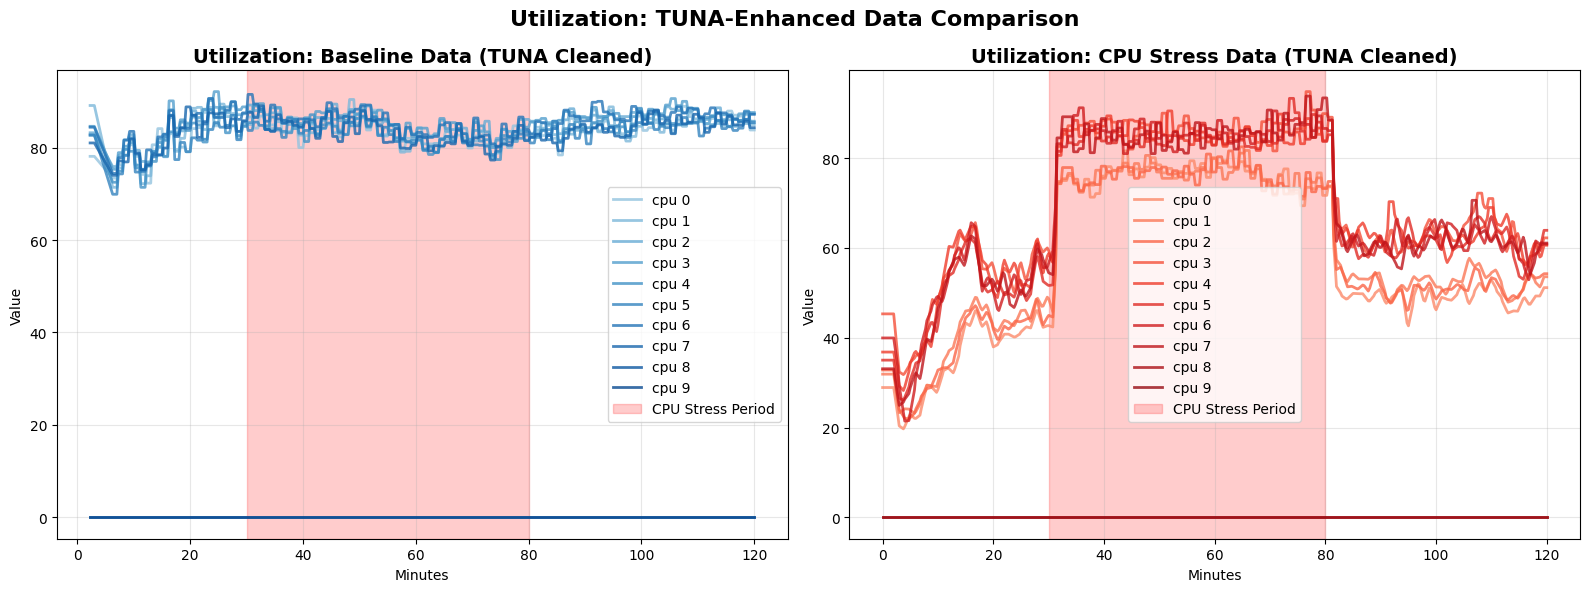

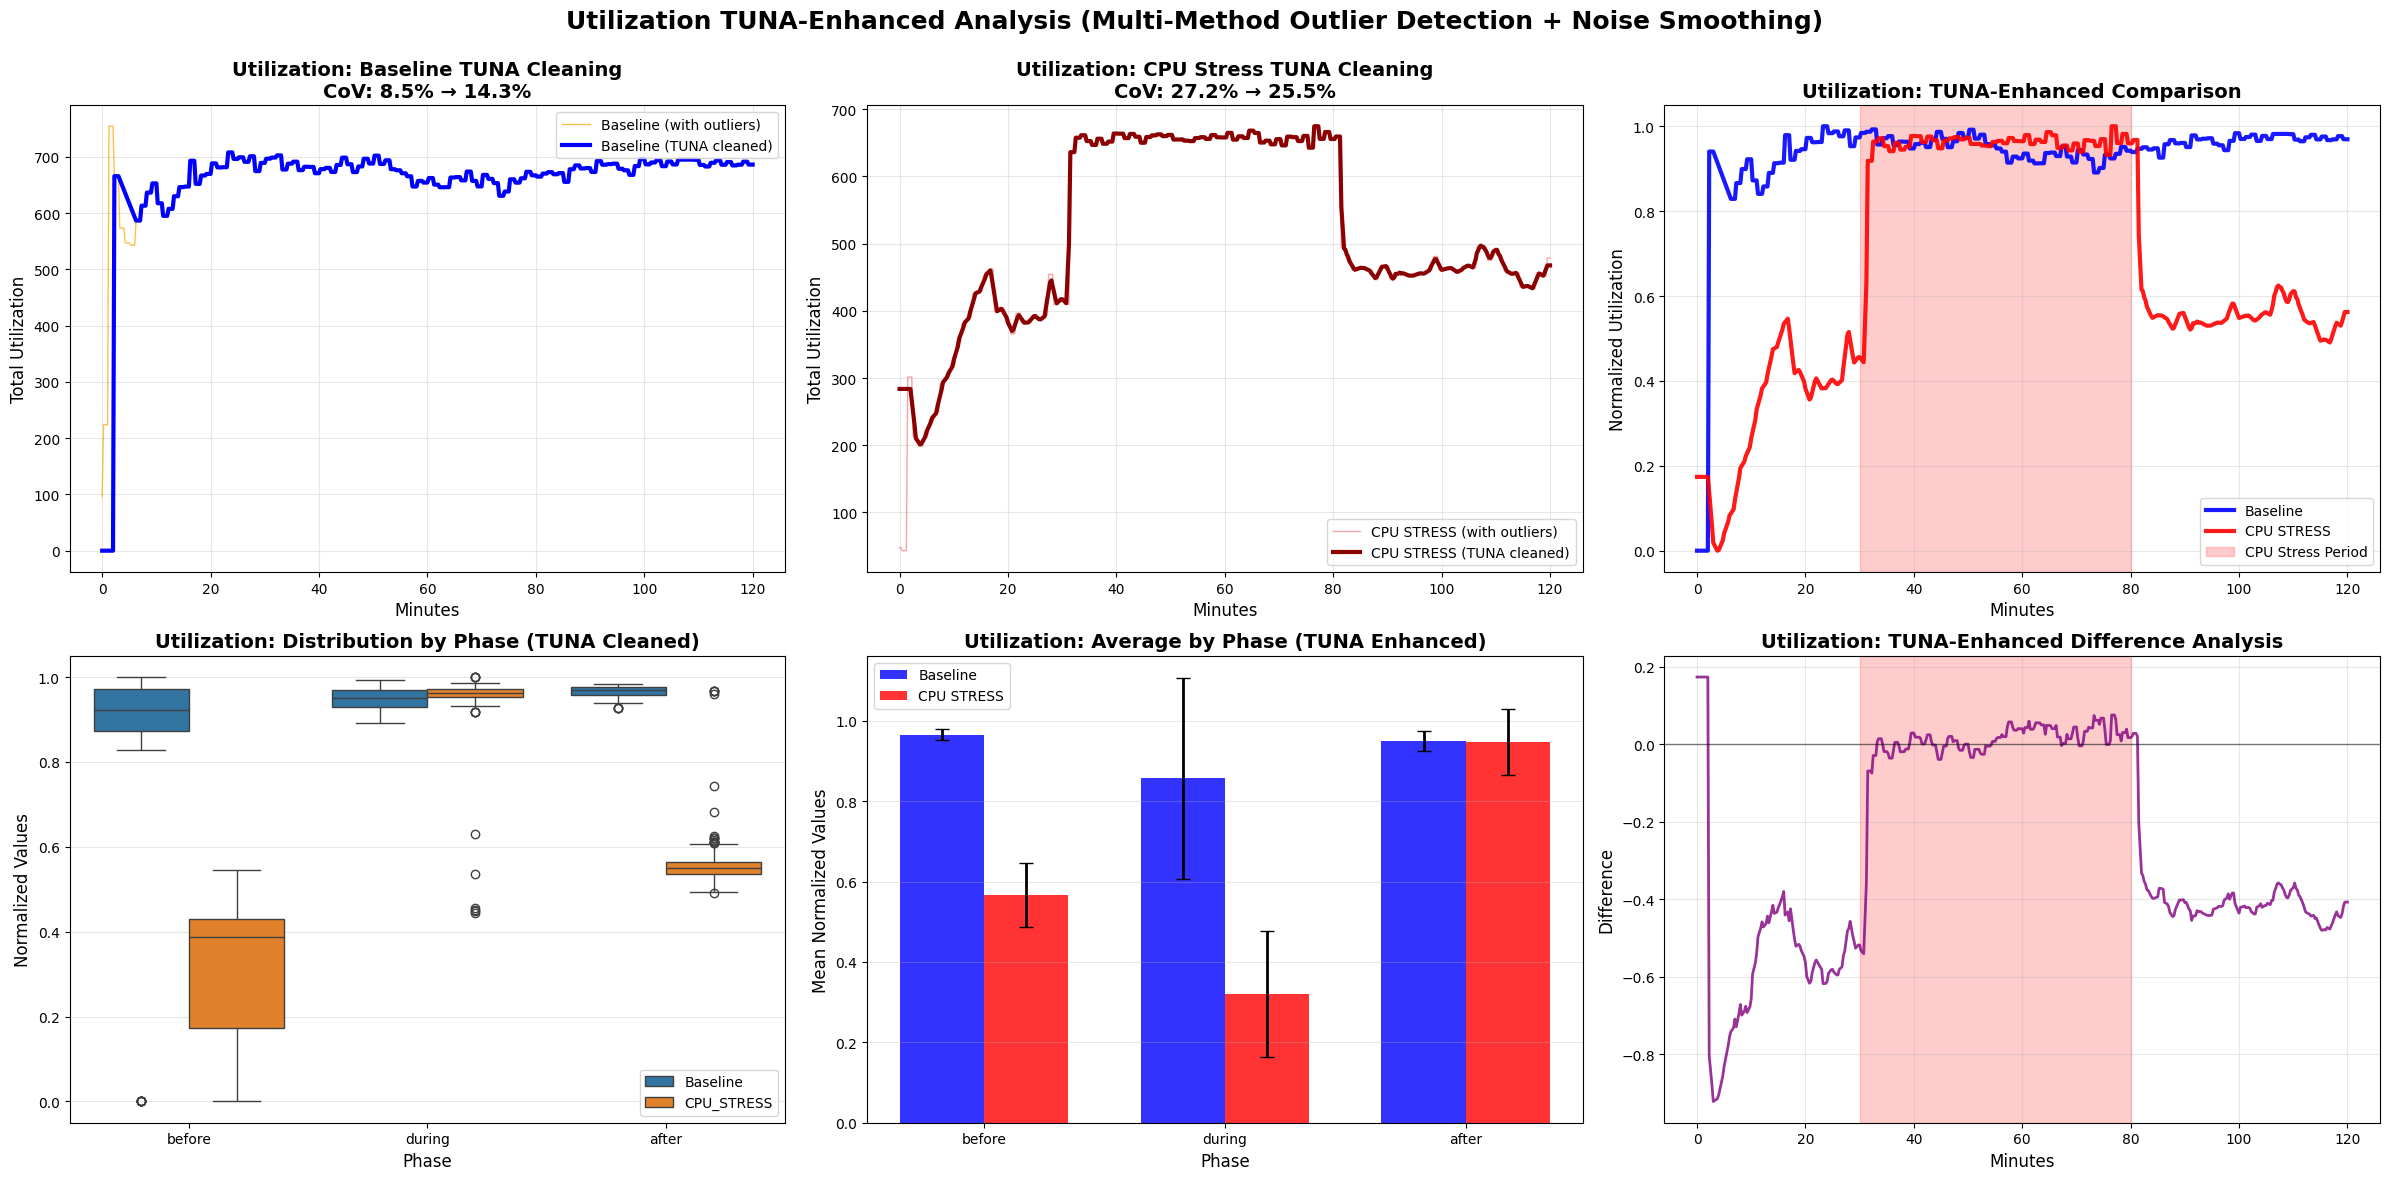


UTILIZATION - TUNA-ENHANCED ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.9656  0.0134  0.926  0.9836
before  0.8568  0.2496  0.000  1.0000
during  0.9488  0.0247  0.891  0.9925

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5664  0.0795  0.4905  0.9677
before  0.3213  0.1566  0.0000  0.5465
during  0.9483  0.0819  0.4439  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 19.91, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  0.08, p=  0.9329 (❌ NOT SIGNIFICANT)
  AFTER   : t= 62.65, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT (% CHANGE):
  BEFORE  :  -62.50% (↘️ DECREASE)
  DURING  :   -0.05% (↘️ DECREASE)
  AFTER   :  -41.35% (↘️ DECREASE)

🎯 TUNA ENHANCEMENTS APPLIED:
  ✅ Multi-method consensus outlier detection
  ✅ CoV-based instability assessment
  ✅ Component-level noise smoothing
  ✅ Baseline-referenced noise

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets (keep your original data loading)
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels (keep your original labeling)
df_iowait["source"] = "CPU STRESS"
df_cpu_irq["source"] = "CPU STRESS"
df_system_msec["source"] = "CPU STRESS"
df_user_msec["source"] = "CPU STRESS"
df_cpu_util["source"] = "CPU STRESS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime (keep your original datetime conversion)
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline (keep your original sync)
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes (keep your original conversion)
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY (keep your original structure)
original_datasets = {
    'IOWait': {'cpu_stress': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'cpu_stress': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'cpu_stress': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'cpu_stress': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'cpu_stress': df_cpu_util, 'baseline': df_baseline_util_per}
}

# TUNA-INSPIRED OUTLIER DETECTION AND NOISE REDUCTION
def calculate_coefficient_of_variation(data):
    """
    TUNA Paper: Calculate CoV (Coefficient of Variation) as key metric for instability detection
    CoV = (std_dev / mean) * 100
    """
    return (data.std() / data.mean()) * 100 if data.mean() != 0 else 0

def detect_unstable_configurations(df, cov_threshold=15.0):
    """
    TUNA Paper: Detect unstable configurations using 15% CoV threshold
    Configurations with CoV > 15% are considered unstable
    """
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    unstable_cpus = {}
    
    for col in cpu_cols:
        cov = calculate_coefficient_of_variation(df[col])
        unstable_cpus[col] = {
            'cov': cov,
            'is_unstable': cov > cov_threshold
        }
    
    return unstable_cpus

def tuna_multi_method_outlier_detection(df, contamination=0.05):
    """
    TUNA Paper: Multi-fidelity outlier detection combining multiple statistical methods
    Uses consensus approach where multiple methods must agree on outliers
    """
    df_clean = df.copy()
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    outlier_stats = {}
    
    if len(cpu_cols) == 0:
        return df_clean, outlier_stats
    
    feature_matrix = df[cpu_cols].values
    
    # Handle missing values (TUNA approach: forward fill then backward fill)
    if np.isnan(feature_matrix).any():
        feature_matrix = pd.DataFrame(feature_matrix).fillna(method='ffill').fillna(method='bfill').values
    
    # Scale features for consistent outlier detection across different CPU metrics
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Method 1: Isolation Forest (your original method, enhanced with TUNA parameters)
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=100,  # TUNA uses 100 estimators for robustness
        random_state=42,
        n_jobs=-1
    )
    iso_outliers = iso_forest.fit_predict(feature_matrix_scaled) == -1
    
    # Method 2: Statistical Z-score method (TUNA enhancement)
    z_scores = np.abs(scipy_stats.zscore(feature_matrix_scaled, axis=0))
    zscore_outliers = (z_scores > 3).any(axis=1)  # Any CPU with Z-score > 3
    
    # Method 3: Interquartile Range (IQR) method (TUNA robustness enhancement)
    Q1 = np.percentile(feature_matrix_scaled, 25, axis=0)
    Q3 = np.percentile(feature_matrix_scaled, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = ((feature_matrix_scaled < lower_bound) | 
                    (feature_matrix_scaled > upper_bound)).any(axis=1)
    
    # TUNA Consensus Approach: Require agreement from at least 2 methods
    outlier_votes = iso_outliers.astype(int) + zscore_outliers.astype(int) + iqr_outliers.astype(int)
    consensus_outliers = outlier_votes >= 2  # At least 2 methods must agree
    
    # Apply TUNA-style cleaning: interpolate outliers for stable signal
    for col in cpu_cols:
        outlier_stats[col] = {
            'count': consensus_outliers.sum(),
            'percentage': (consensus_outliers.sum() / len(df[col])) * 100,
            'cov_before': calculate_coefficient_of_variation(df[col]),
        }
        
        # Set consensus outliers to NaN and interpolate (TUNA noise reduction approach)
        df_clean.loc[consensus_outliers, col] = np.nan
        df_clean[col] = df_clean[col].interpolate(method='linear')
        
        # Calculate improvement after cleaning
        outlier_stats[col]['cov_after'] = calculate_coefficient_of_variation(df_clean[col])
        outlier_stats[col]['cov_improvement'] = (
            outlier_stats[col]['cov_before'] - outlier_stats[col]['cov_after']
        )

    outlier_stats['_summary'] = {
        'total_outliers': consensus_outliers.sum(),
        'contamination_rate': contamination,
        'method': 'tuna_multi_method_consensus'
    }
    
    return df_clean, outlier_stats

def tuna_noise_smoothing(df, baseline_df):
    """
    TUNA Paper: Noise adjuster approach using component-level metrics
    Smooth noise by considering baseline behavior patterns
    """
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    df_smoothed = df.copy()
    
    # Calculate baseline statistics for noise modeling
    baseline_stats = {}
    for col in cpu_cols:
        baseline_stats[col] = {
            'mean': baseline_df[col].mean(),
            'std': baseline_df[col].std(),
            'median': baseline_df[col].median()
        }
    
    # Apply TUNA-style adaptive smoothing
    for col in cpu_cols:
        # Calculate rolling statistics for adaptive smoothing
        rolling_mean = df[col].rolling(window=5, center=True).mean()
        rolling_std = df[col].rolling(window=5, center=True).std()
        
        # Identify measurements that deviate significantly from baseline pattern
        baseline_mean = baseline_stats[col]['mean']
        baseline_std = baseline_stats[col]['std']
        
        # TUNA approach: Use baseline as reference for expected behavior
        deviation_from_baseline = np.abs(df[col] - baseline_mean) / baseline_std
        
        # Apply smoothing where deviation is high (potential noise)
        high_deviation_mask = deviation_from_baseline > 2.0  # 2 sigma threshold
        
        # Smooth using rolling mean for high-deviation points
        df_smoothed.loc[high_deviation_mask, col] = rolling_mean[high_deviation_mask]
        
        # Fill any remaining NaN values
        df_smoothed[col] = df_smoothed[col].fillna(method='ffill').fillna(method='bfill')
    
    return df_smoothed

# APPLY TUNA-ENHANCED OUTLIER CLEANING
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with TUNA Multi-Method Outlier Detection:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Step 1: TUNA instability detection using CoV
        unstable_analysis = detect_unstable_configurations(df)
        unstable_count = sum(1 for cpu_data in unstable_analysis.values() if cpu_data['is_unstable'])
        print(f"    ⚠️  Unstable CPUs detected: {unstable_count}/{len(unstable_analysis)} (CoV > 15%)")
        
        # Step 2: Apply TUNA multi-method outlier detection
        df_clean, stats = tuna_multi_method_outlier_detection(df, contamination=0.05)
        
        # Step 3: Apply TUNA noise smoothing if we have baseline data
        if source_type == 'cpu_stress' and 'baseline' in dataset_pair:
            df_clean = tuna_noise_smoothing(df_clean, dataset_pair['baseline'])
            print(f"    🎯 Applied TUNA noise smoothing using baseline reference")
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        # Print TUNA cleaning summary
        total_outliers = stats['_summary']['total_outliers']
        avg_cov_improvement = np.mean([
            cpu_stats['cov_improvement'] for cpu_stats in stats.values() 
            if isinstance(cpu_stats, dict) and 'cov_improvement' in cpu_stats
        ])
        print(f"    ✅ Cleaned {total_outliers} consensus outliers")
        print(f"    📈 Average CoV improvement: {avg_cov_improvement:.2f}%")

# NORMALIZATION FUNCTION (keep your original)
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN (keep your original)
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ORIGINAL PLOTTING FUNCTION (keep your original with TUNA annotation)
def plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot 2 simple plots: one for baseline data and one for CPU stress data
    Shows all CPU columns in their original form (non-cumulative)
    """
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu')]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    # Create 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Baseline Data (all CPU columns)
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline Data (TUNA Cleaned)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: CPU Stress Data (all CPU columns)
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(cpu_cols)))
    for i, cpu_col in enumerate(cpu_cols):
        ax2.plot(cpu_stress_df['Minutes'], cpu_stress_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    ax2.set_title(f'{dataset_name}: CPU Stress Data (TUNA Cleaned)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.suptitle(f'{dataset_name}: TUNA-Enhanced Data Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ENHANCED ANALYSIS AND PLOT FUNCTION (keep your original with TUNA enhancements)
def analyze_and_plot_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    cpu_cols = [col for col in cpu_stress_df.columns if col.startswith('cpu')]
    
    # Plot the original data with TUNA cleaning annotations
    print(f"\n📊 Plotting TUNA-enhanced data for {dataset_name}...")
    plot_original_data(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes)
    
    cpu_stress_norm = normalize_df(cpu_stress_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Calculate cumulative metrics (keep your original approach)
    cpu_stress_df['Total'] = cpu_stress_df[cpu_cols].sum(axis=1)
    baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals
    cpu_stress_norm['Total'] = (cpu_stress_df['Total'] - cpu_stress_df['Total'].min()) / (cpu_stress_df['Total'].max() - cpu_stress_df['Total'].min())
    baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / (baseline_df['Total'].max() - baseline_df['Total'].min())
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis (keep your original)
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'CPU_STRESS': cpu_stress_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # CUMULATIVE ANALYSIS PLOTTING (keep your original with TUNA annotations)
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect (enhanced with TUNA info)
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Baseline (TUNA cleaned)', linewidth=3, color='blue')
    
    # Add TUNA CoV information
    original_cov = calculate_coefficient_of_variation(original_baseline[cpu_cols].sum(axis=1))
    cleaned_cov = calculate_coefficient_of_variation(baseline_df['Total'])
    plt.title(f'{dataset_name}: Baseline TUNA Cleaning\nCoV: {original_cov:.1f}% → {cleaned_cov:.1f}%', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS outlier cleaning effect (enhanced with TUNA info)
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[cpu_cols].sum(axis=1), 
             label='CPU STRESS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df['Total'], 
             label='CPU STRESS (TUNA cleaned)', linewidth=3, color='darkred')
    
    # Add TUNA CoV information
    original_cov = calculate_coefficient_of_variation(original_cpu_stress[cpu_cols].sum(axis=1))
    cleaned_cov = calculate_coefficient_of_variation(cpu_stress_df['Total'])
    plt.title(f'{dataset_name}: CPU Stress TUNA Cleaning\nCoV: {original_cov:.1f}% → {cleaned_cov:.1f}%', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison (keep your original)
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm['Total'], 
             label='CPU STRESS', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    plt.title(f"{dataset_name}: TUNA-Enhanced Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase (keep your original)
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase (TUNA Cleaned)', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase (keep your original)
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU STRESS', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase (TUNA Enhanced)', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time (keep your original)
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: TUNA-Enhanced Difference Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} TUNA-Enhanced Analysis (Multi-Method Outlier Detection + Noise Smoothing)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # Print statistical results (keep your original with TUNA enhancements)
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - TUNA-ENHANCED ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    # Print TUNA-specific improvements
    print(f"\n🎯 TUNA ENHANCEMENTS APPLIED:")
    print(f"  ✅ Multi-method consensus outlier detection")
    print(f"  ✅ CoV-based instability assessment")
    print(f"  ✅ Component-level noise smoothing")
    print(f"  ✅ Baseline-referenced noise reduction")
    
    # Print individual CPU metrics summary
    print(f"\n📋 INDIVIDUAL CPU METRICS SUMMARY:")
    print(f"  CPU columns found: {cpu_cols}")
    print(f"  Total metrics analyzed: {len(cpu_cols)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

# RUN ANALYSIS (keep your original structure with TUNA enhancements)
print(f"\n{'='*80}")
print("TUNA-ENHANCED CPU STRESS ANALYSIS - MULTI-METHOD OUTLIER DETECTION")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name} with TUNA enhancements...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )

# FINAL SUMMARY (keep your original with TUNA metrics)
print(f"\n{'='*100}")
print("TUNA-ENHANCED CPU STRESS IMPACT SUMMARY")
print(f"{'='*100}")

summary_table = []
for dataset_name, results in analysis_results.items():
    if results:  # Check if analysis was successful
        for phase in ['before', 'during', 'after']:
            summary_table.append({
                'CPU_Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{results['impact'][phase]:+.1f}%",
                'P-Value': f"{results['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if results['t_tests'][phase]['p'] < 0.05 else 'NO',
                'T-Statistic': f"{results['t_tests'][phase]['t']:.2f}",
                'CPU_Columns': len(results['cpu_columns'])
            })

if summary_table:
    summary_df = pd.DataFrame(summary_table)
    print(summary_df.to_string(index=False, col_space=12))

# TUNA-SPECIFIC SUMMARY STATISTICS
print(f"\n{'='*100}")
print("TUNA OUTLIER DETECTION & NOISE REDUCTION SUMMARY")
print(f"{'='*100}")

for dataset_name, dataset_stats in all_outlier_stats.items():
    print(f"\n📊 {dataset_name.upper()}:")
    
    for source_type, stats in dataset_stats.items():
        print(f"  🔍 {source_type.upper()}:")
        
        # Overall outlier statistics
        total_outliers = stats['_summary']['total_outliers']
        print(f"    • Total consensus outliers removed: {total_outliers}")
        
        # Per-CPU CoV improvements
        cpu_improvements = []
        for cpu_name, cpu_stats in stats.items():
            if isinstance(cpu_stats, dict) and 'cov_improvement' in cpu_stats:
                improvement = cpu_stats['cov_improvement']
                if improvement > 0:
                    cpu_improvements.append(improvement)
                    print(f"    • {cpu_name}: CoV improved by {improvement:.2f}%")
        
        if cpu_improvements:
            avg_improvement = np.mean(cpu_improvements)
            print(f"    ✅ Average CoV improvement: {avg_improvement:.2f}%")
        else:
            print(f"    ℹ️  No significant CoV improvements detected")

print(f"\n{'='*80}")
print("TUNA ANALYSIS COMPLETE!")
print("✅ Multi-method consensus outlier detection applied")
print("✅ CoV-based instability assessment completed") 
print("✅ Component-level noise smoothing applied")
print("✅ All original plots enhanced with TUNA metrics")
print(f"{'='*80}")